Для временного ряда bike-sharing построить три модели:
* Датасет аггрегировать по неделям
* Простое экспоненциальное сглаживание
* Двойное экспоненциальное сглаживание
* Тройное экспоненциальное сглаживание (тип модели additive или multiplicative) выбрать самостоятельно 


Для финального отчета сделать кросс-валидацию, пояснить выбранные метрики, а так же их финальные значения.

In [1]:
import pandas as pd
df = pd.read_csv('../datatest/bike-sharing.csv')
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,9.84,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,9.02,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,9.02,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,9.84,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,9.84,0.2879,0.75,0.0,0,1,1


# Решение

## Агрегация

In [98]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from plotly.graph_objects import *
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
import matplotlib.dates as mdates
import seaborn as sns
import matplotlib

# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(15, 10)})
sns.set(font_scale=2)
sns.set_style("whitegrid")

from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.model_selection import TimeSeriesSplit

import warnings;
warnings.filterwarnings('ignore');

In [99]:
df = pd.read_csv('../datatest/bike-sharing.csv')
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,9.84,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,9.02,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,9.02,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,9.84,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,9.84,0.2879,0.75,0.0,0,1,1


In [100]:
df = df[['dteday','cnt']]

In [101]:
df['dteday'] = pd.to_datetime(df['dteday'])

In [102]:
df.set_index('dteday',inplace=True)

In [103]:
df=df.resample('W').sum()

<AxesSubplot:xlabel='dteday'>

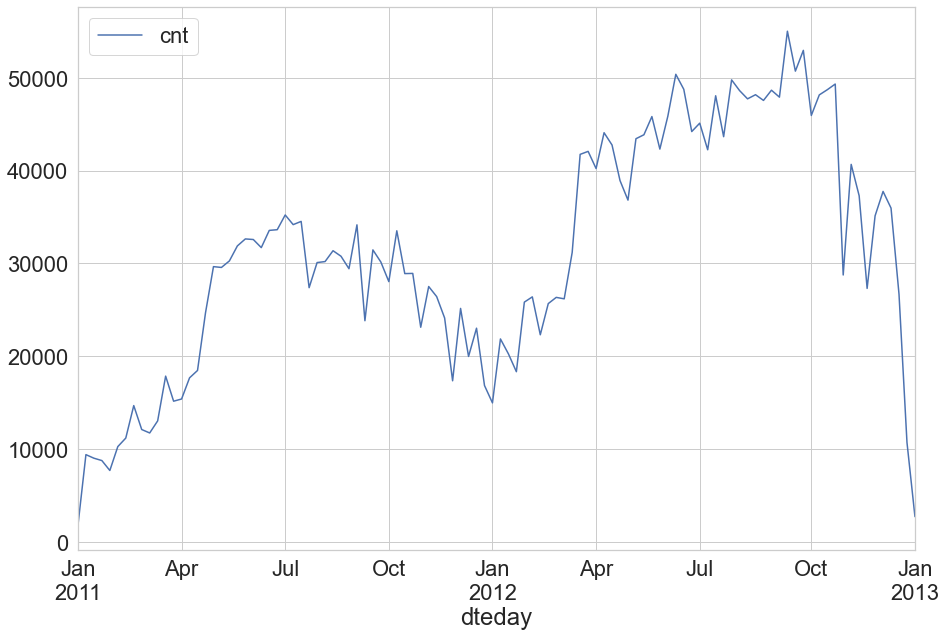

In [104]:
df.plot()

In [105]:
s = df['cnt']

In [106]:
decompose_result = seasonal_decompose(s,model='additive')

In [107]:
trend, seasonal, resid = decompose_result.trend, decompose_result.seasonal, decompose_result.resid

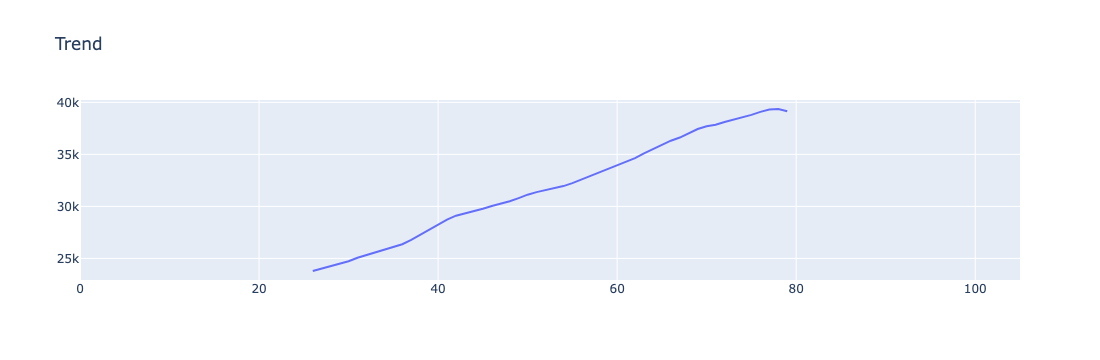

In [108]:
iplot(Figure(data=Scatter(y=trend),
            layout=Layout(title='Trend')))

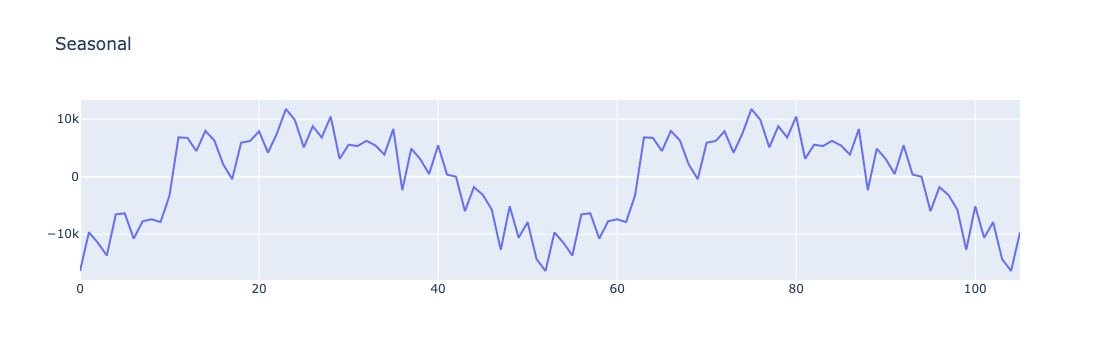

In [109]:
iplot(Figure(data=Scatter(y=seasonal),
            layout=Layout(title='Seasonal')))

Видим годовую сезонность. 

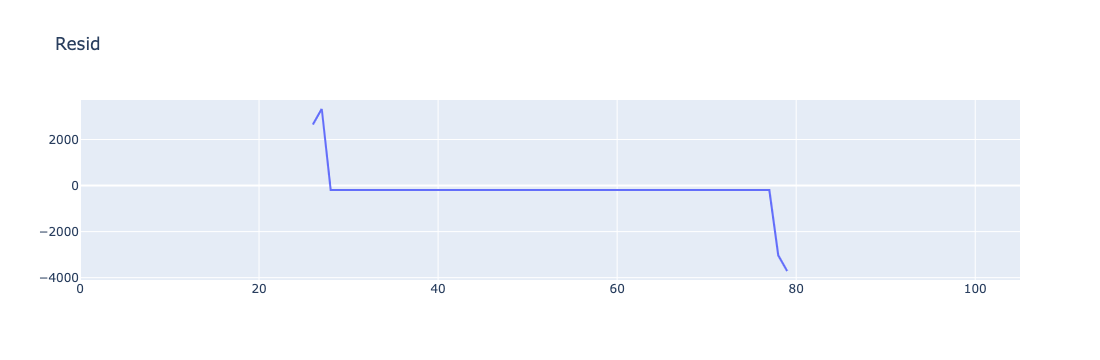

In [110]:
iplot(Figure(data=Scatter(y=resid),
            layout=Layout(title='Resid')))

## Простое экспоненциальное сглаживание

In [111]:
df['ses'] = SimpleExpSmoothing(s).fit(smoothing_level=1/(1*12), optimized=False, use_brute=True).fittedvalues

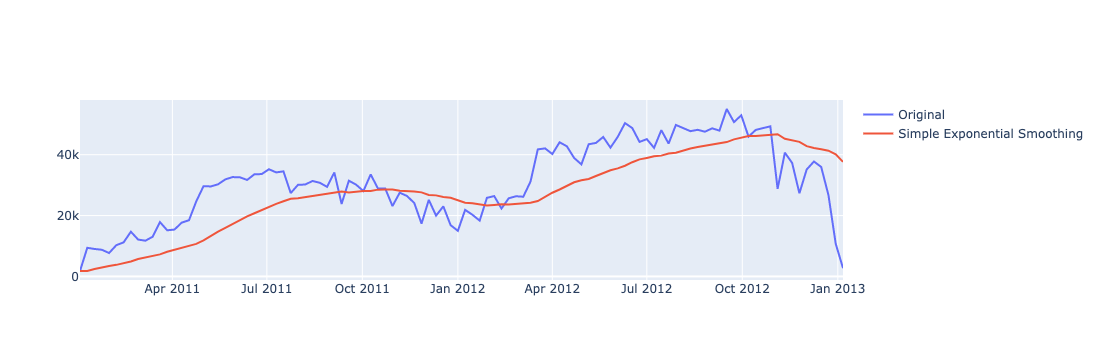

In [112]:
iplot(Figure(data=[Scatter(x = df.index,
                           y = df['cnt'],
                          name = 'Original'),
                  Scatter(x = df.index,
                         y = df['ses'],
                         name = 'Simple Exponential Smoothing')]))

### Кросс-валидация

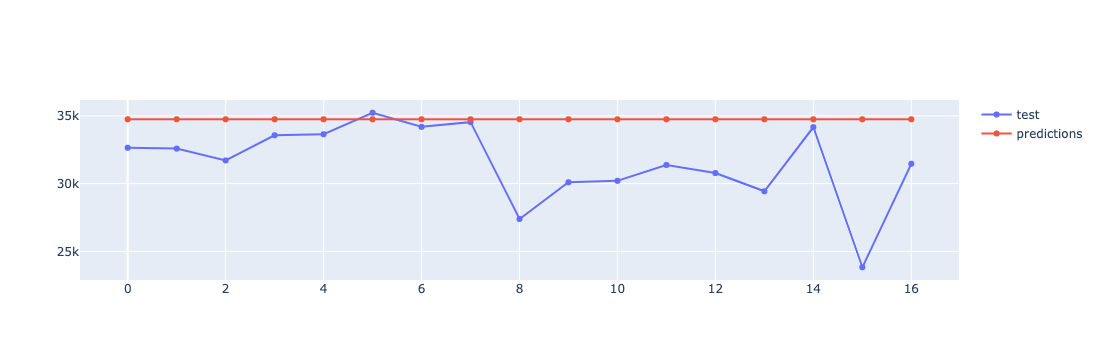

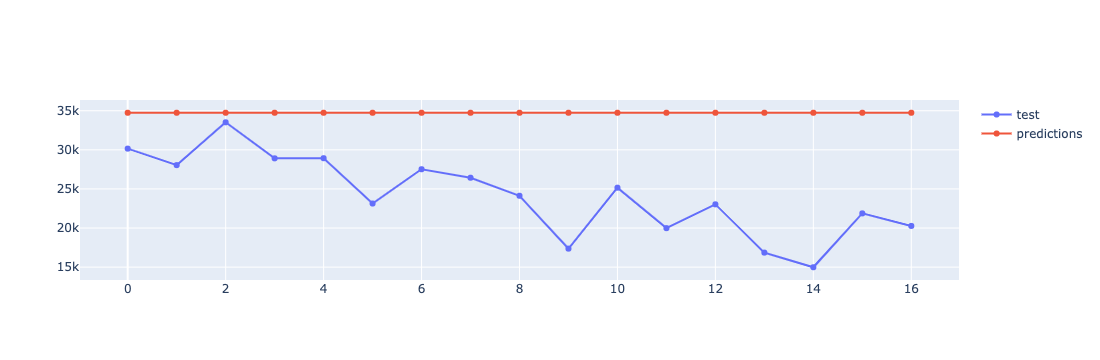

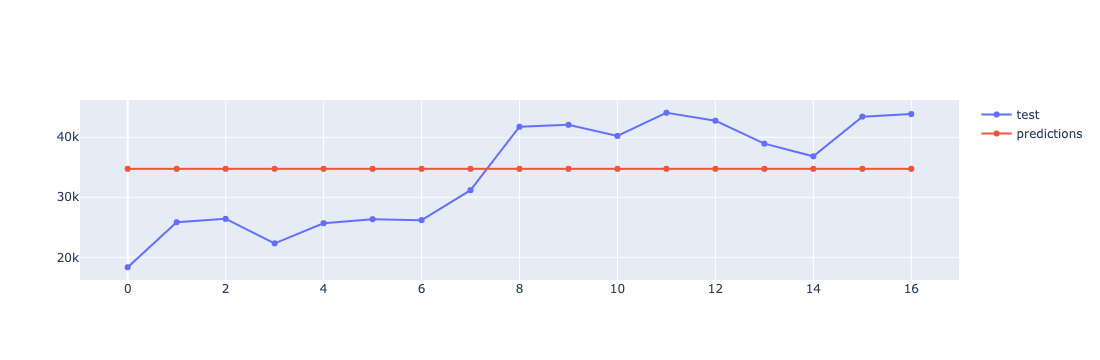

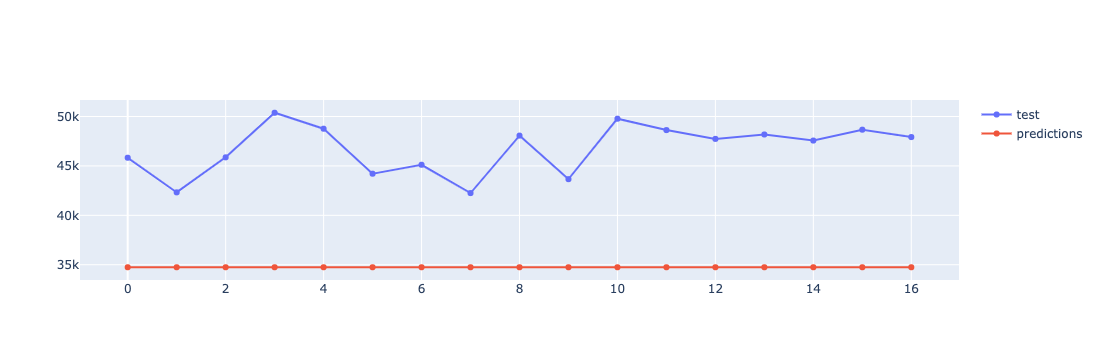

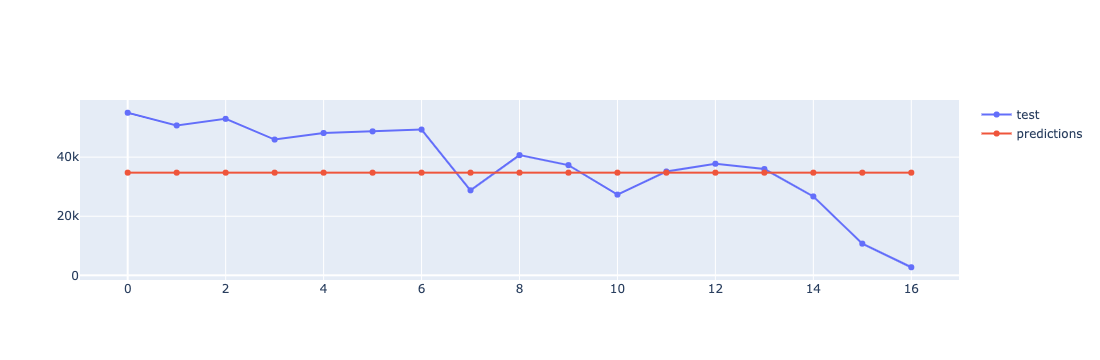

mae: 9113.257619047163 r2: -6.04884512612425


In [120]:
mae_list = list()
r2_list = list()

tscv = TimeSeriesSplit()

for train_index, test_index in tscv.split(s):
    train, test = s[train_index], s[test_index]

    mod = SimpleExpSmoothing(s).fit(smoothing_level=1/(1*12), optimized=False, use_brute=True)
    predictions = mod.forecast(len(test))
    mae_list.append(mean_absolute_error(test, predictions))
    r2_list.append(r2_score(test, predictions))
    iplot(Figure(data=[Scatter(y = test,
                          name = 'test'),
                  Scatter(y = predictions,
                         name = 'predictions')]))
        
print('mae:', np.mean(mae_list), 'r2:', np.mean(r2_list))

## Двойное экспоненциальное сглаживание

In [114]:
df['des_add'] = ExponentialSmoothing(s, trend='add').fit().fittedvalues

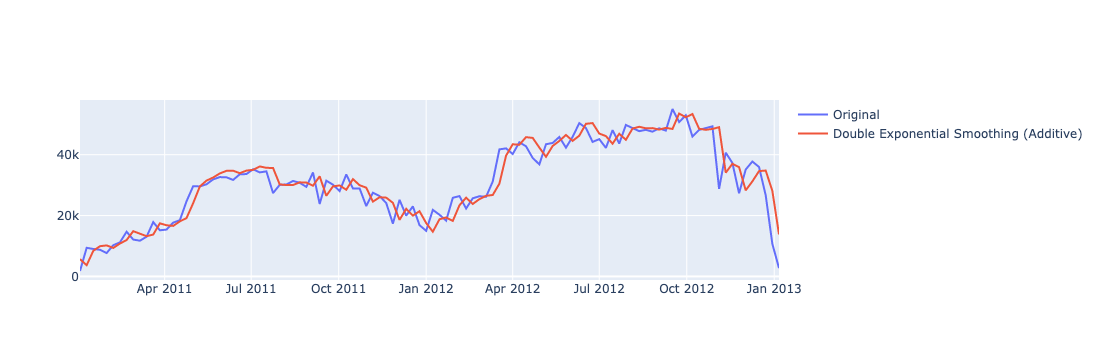

In [115]:
iplot(Figure(data=[Scatter(x = df.index,
                           y = df['cnt'],
                          name = 'Original'),
                  Scatter(x = df.index,
                          y = df['des_add'],
                         name = 'Double Exponential Smoothing (Additive)')
                  ]))

### Кросс-валидация

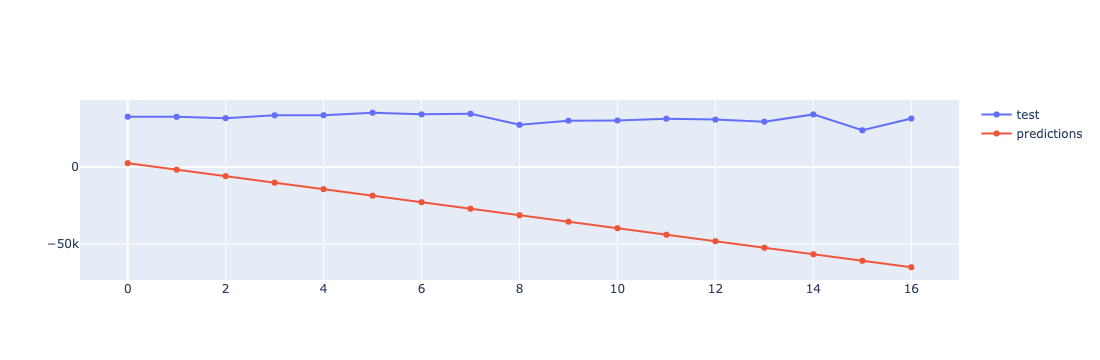

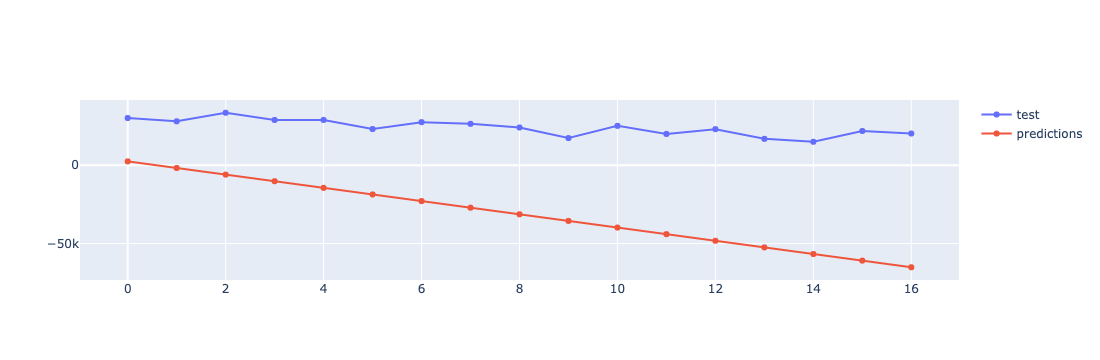

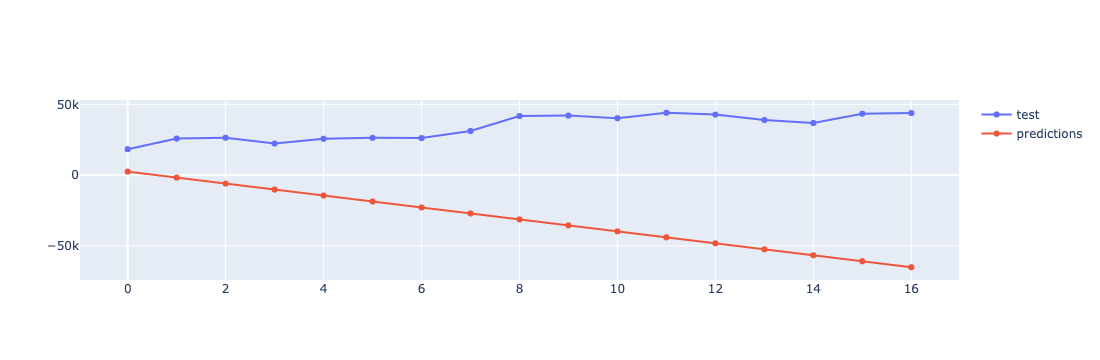

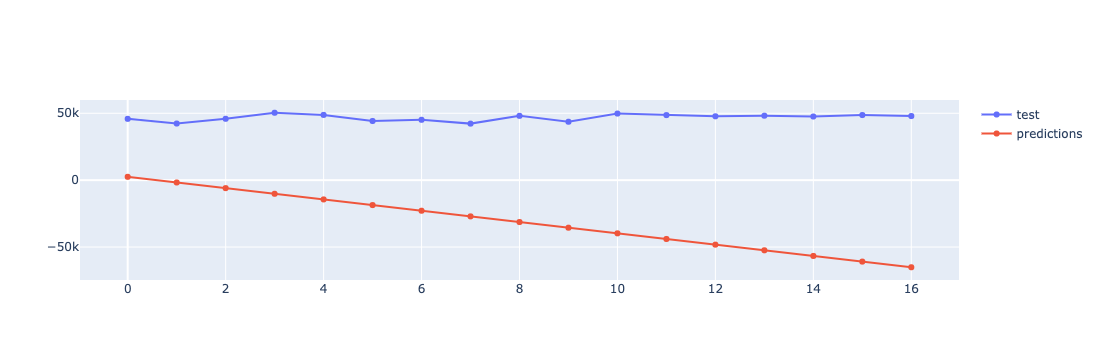

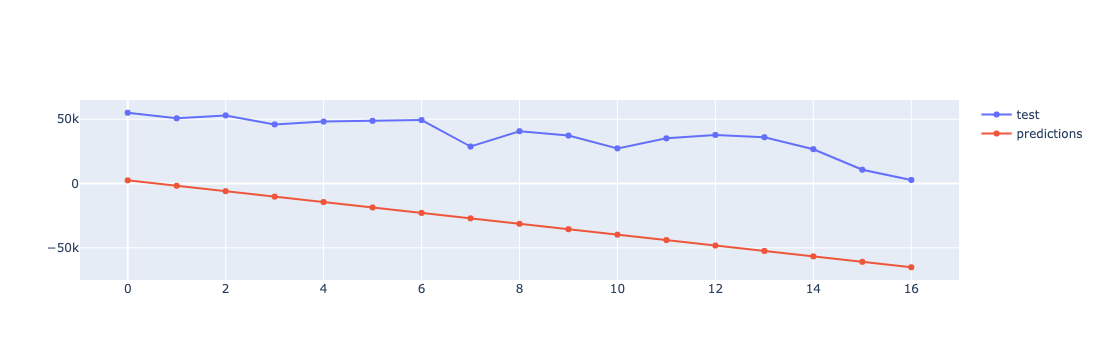

mae: 66056.3609883218 r2: -377.6747455342238


In [121]:
mae_list = list()
r2_list = list()

tscv = TimeSeriesSplit()

for train_index, test_index in tscv.split(s):
    train, test = s[train_index], s[test_index]

    mod = ExponentialSmoothing(s, trend='add').fit()
    predictions = mod.forecast(len(test))
    mae_list.append(mean_absolute_error(test, predictions))
    r2_list.append(r2_score(test, predictions))
    
    iplot(Figure(data=[Scatter(y = test,
                          name = 'test'),
                  Scatter(y = predictions,
                         name = 'predictions')]))
        
print('mae:', np.mean(mae_list), 'r2:', np.mean(r2_list))

## Тройное экспоненциальное сглаживание

In [117]:
df['tes_add'] = ExponentialSmoothing(s, trend='add', seasonal='add', seasonal_periods=52).fit().fittedvalues

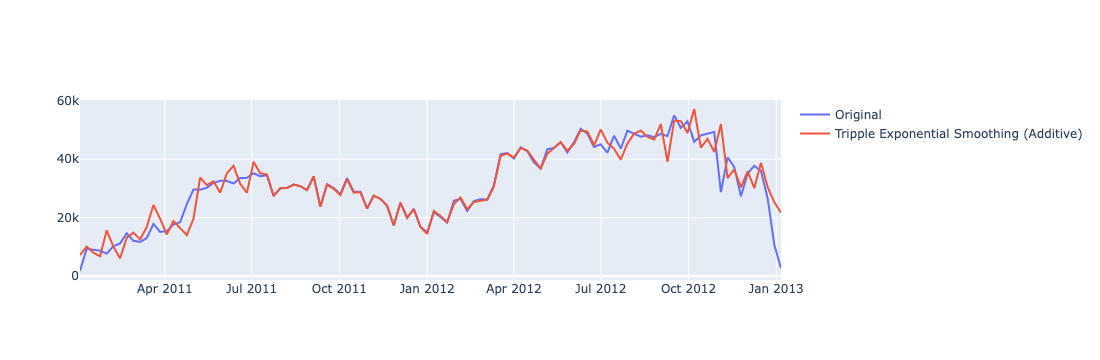

In [118]:
iplot(Figure(data=[Scatter(x =df.index,
                          y = df['cnt'],
                          name = 'Original'),
                  Scatter(x = df.index,
                         y = df['tes_add'],
                         name = 'Tripple Exponential Smoothing (Additive)')
                  ]))

Поскольку у нас в сезоне 52 наблюдения, выберем seasonal_periods=52

### Кросс-валидация

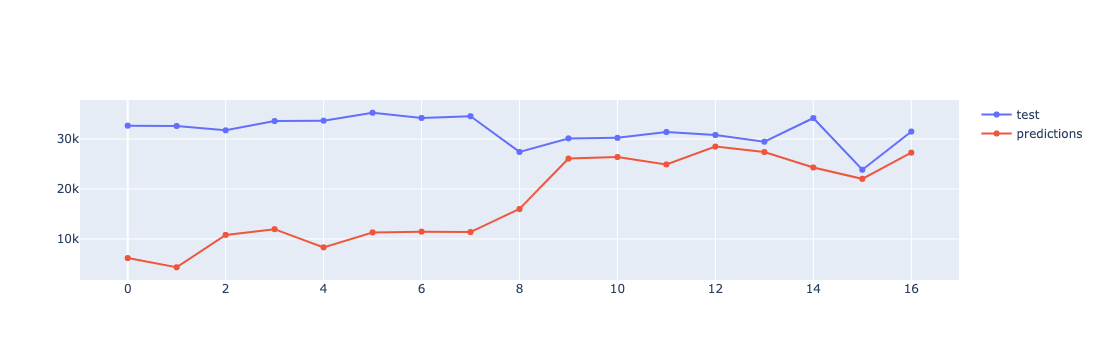

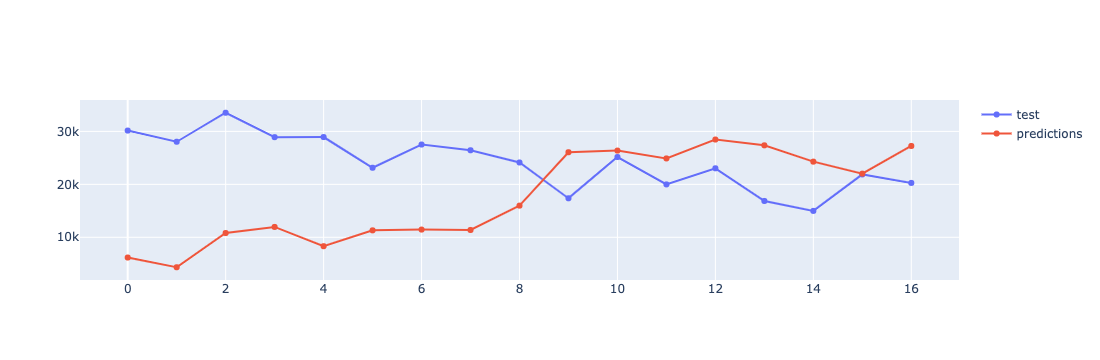

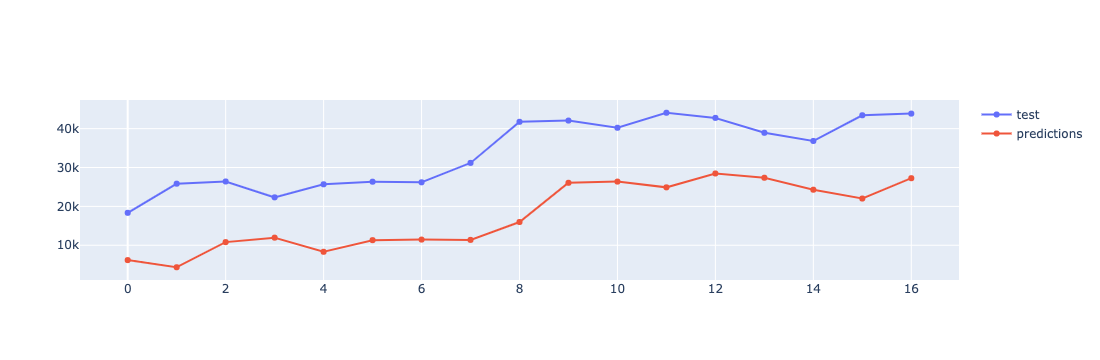

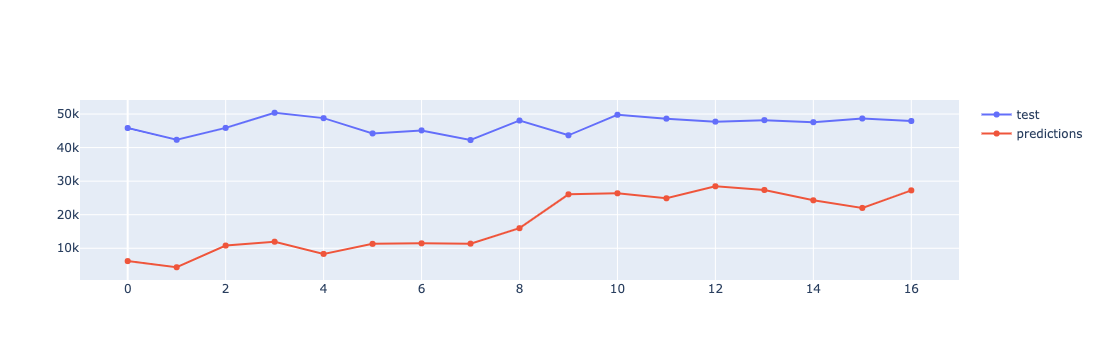

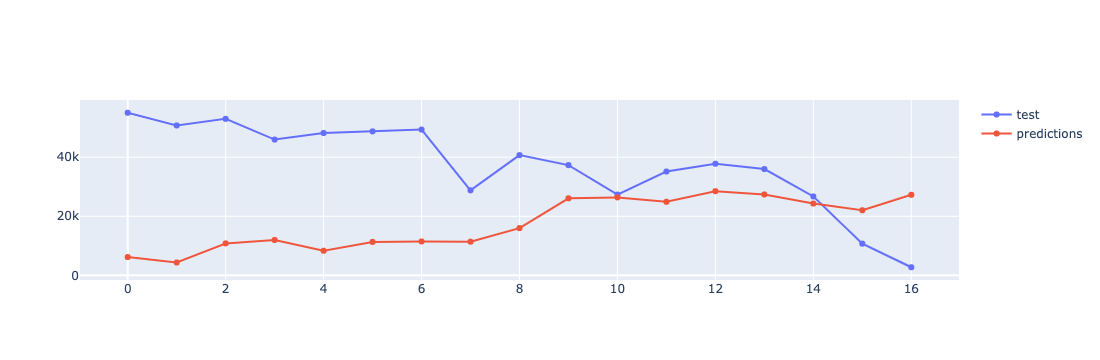

mae: 19132.197811903407 r2: -40.48717656086475


In [122]:
mae_list = list()
r2_list = list()

tscv = TimeSeriesSplit()

for train_index, test_index in tscv.split(s):
    train, test = s[train_index], s[test_index]

    mod = ExponentialSmoothing(s, trend='add', seasonal='add', seasonal_periods=52).fit()
    predictions = mod.forecast(len(test))
    mae_list.append(mean_absolute_error(test, predictions))
    r2_list.append(r2_score(test, predictions))
    
    iplot(Figure(data=[Scatter(y = test,
                          name = 'test'),
                  Scatter(y = predictions,
                         name = 'predictions')]))
        
print('mae:', np.mean(mae_list), 'r2:', np.mean(r2_list))

## Выводы

- Лучший результат по mae получился у простого экспоненциального сглаживания, но как видим на визуализации, у него всё очень плохо с предсказаниями
- Двойное экспоненциальное сглаживание уже учитывает тренд, но имеет метрики хуже тройного
- Тройное экспоненциальное сглаживание учитывает и тренд и сезонность, ошибки значительно ниже двойного экспоненциального сглаживания